This file contains some functions for the QC steps. Functions are tested on an APC table.
I assume the tables from different years are merged.

# Connection

In [383]:
import pandas as pd
import matplotlib.pyplot as plt
import pyodbc
import sqlalchemy
import numpy as np

%matplotlib inline

In [349]:
def connect():
    return pyodbc.connect(
        'DRIVER={/usr/lib/x86_64-linux-gnu/odbc/libtdsodbc.so}; SERVER=192.168.5.78;'
        'DATABASE=IMS-NHSDigital;UID=sa;PWD=2HsxpmkDLSlHlT;port=1433;'
        'TDS_Version=8.0;')
engine = sqlalchemy.create_engine('mssql+pyodbc://', creator=connect)
conn = engine.connect()

/home/vsalvatelli/anaconda3/lib/python3.6/site-packages/sqlalchemy/connectors/pyodbc.py:92: SAWarning: No driver name specified; this is expected by PyODBC when using DSN-less connections
  "No driver name specified; "


# Check on positive patients

Check that positive patients in IMS-NHSDigital database corresponds to the positive patients in Shieffield database (table from Flora) in terms of:

* HES ID
* birth year
* gender
* whether or not they had right heart catherer at Sheffield

## Check that the HES IDs are the same

In [350]:
#collect unique HES_IDs from NHSDigital
#Tablename will be something like APC_positive, hopefully all tables merged
tablename='dbo.NIC58999_APC_Linkage_201299'
label_ID= 'ENCRYPTED_HESID'

query= 'SELECT ' + label_ID +' from ' + tablename

positive_IDs= pd.read_sql(query, conn)['ENCRYPTED_HESID'].unique()

In [351]:
#read ID columns from reference file
Sheffdb_tablename= '/home/vsalvatelli/SharedData/Patient_group_file_SQL_v2.xlsx'
#there will be a 'ENCRYPTED_HESID' column
Sheffdb_label_ID= 'STHFT_Study_ID'

#these should be already unique IDs, but just in case
Sheffield_pos_IDs=pd.read_excel(Sheffdb_tablename)[Sheffdb_label_ID].unique()

In [352]:
#basic test: is the number of patients the same?
len(positive_IDs)==len(Sheffield_pos_IDs)

False

In [353]:
#second test: are the IDs the same?
#if the two lists are identical this returns True (the order matters in the equivalence)
import re
def alphanumeric_sort(l):
    """ Sorts the given iterable in the way that is expected.

    Required arguments:
    l -- The iterable to be sorted.
    """
    
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)


alphanumeric_sort(positive_IDs) == alphanumeric_sort(Sheffield_pos_IDs)

False

In [354]:
#if the previous test fails, we can check at least if Sheffield_pos_IDs is a subset of positive_IDs (or the opposite)
set(positive_IDs).issubset(set(Sheffield_pos_IDs))

False

## Check that birth date, gender and RHC@Sheffield are the same

In [355]:
#collect info about positives from NHSDigital
#Tablename will be something like APC_positive
tablename='dbo.NIC58999_APC_Linkage_201299'
label_ID= 'ENCRYPTED_HESID'
date_birth= 'MYDOB'
gender='SEX'
hospital= 'PROCODE3'
opertn= ["OPERTN_0" + str(i+1) for i in range(9)] + ["OPERTN_" + str(i+10) for i in range(15)]

cols= [label_ID] + [date_birth] + [gender] + [hospital] + opertn
query= 'SELECT ' + ','.join(cols) +' from ' + tablename 

df_NHS= pd.read_sql(query, conn)

In [356]:
print(df_NHS.shape)
df_NHS.head(5)

(13266, 28)


,ENCRYPTED_HESID,MYDOB,SEX,PROCODE3,OPERTN_01,OPERTN_02,OPERTN_03,OPERTN_04,OPERTN_05,OPERTN_06,...,OPERTN_15,OPERTN_16,OPERTN_17,OPERTN_18,OPERTN_19,OPERTN_20,OPERTN_21,OPERTN_22,OPERTN_23,OPERTN_24
0,18BAC692C0C58B5EE7E7DFD8E6C843CC,121938,1,RWP,-,,,,,,...,,,,,,,,,,
1,F6C2FA7F10D852FD1B9308FF1F0437A9,061945,2,RFS,M479,,,,,,...,,,,,,,,,,
2,E2D507B62FFCEFBD2537D328D6539683,061934,2,RR8,-,,,,,,...,,,,,,,,,,
3,950075F6906AA9E50AFAADD0023C818A,031959,1,REM,X352,,,,,,...,,,,,,,,,,
4,F714475A05E6B6CD6ECE53EFCDD1A8C7,081960,2,RRF,X823,,,,,,...,,,,,,,,,,


In [357]:
# RHQ is the procode3 for Sheffield Teaching Hospitals, 
#is this the right one? Or we need something more specific at 5 digit level?
SHF_procode= 'RHQ'
print(len(df_NHS['ENCRYPTED_HESID'].unique()))
print(sum(df_NHS['PROCODE3']== SHF_procode))

3376
4082


In [358]:
df_NHS['PROCODE3'].value_counts().head(5)

RHQ    4082
RR8     595
RW3     571
RR1     413
REM     406
Name: PROCODE3, dtype: int64

In [359]:
#K65 corresponds to catherisation of hearth
#K65.2 (dot not included in the field) is "catherisation of right side of heart NEC"
RHC_code= 'K652'
#checking that this code appears
res=list()
for name in opertn:
    res.append(sum(df_NHS[name]== RHC_code))
print(res)
print('Total number of RHCs in {}: {}'.format(tablename,sum(res)))
# I am still not checking if several RHCs belong s to the same patient

[612, 25, 3, 3, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total number of RHCs in dbo.NIC58999_APC_Linkage_201299: 653


In [360]:
#add column that says if there is RHC in the opertn cols
#tried to automatically create list of conditions ... to much time to code
#conditions=list()
#for name in opertn:
#    conditions.append(''.join(['df_NHS["', name,'"]', '== "'  ,RHC_code,'"']))

#seems reasonable to check only the first 10 cols (they are in order of priority)
cond1= df_NHS["OPERTN_01"]== RHC_code
cond2= df_NHS["OPERTN_02"]== RHC_code
cond3= df_NHS["OPERTN_03"]== RHC_code
cond4= df_NHS["OPERTN_04"]== RHC_code
cond5= df_NHS["OPERTN_05"]== RHC_code
cond6= df_NHS["OPERTN_06"]== RHC_code
cond7= df_NHS["OPERTN_07"]== RHC_code
cond8= df_NHS["OPERTN_08"]== RHC_code
cond9= df_NHS["OPERTN_09"]== RHC_code
cond10= df_NHS["OPERTN_10"]== RHC_code

#df_NHS['RHC']=df_NHS[(cond1) | (cond2)]
#df_NHS['RHC']=np.where(df_NHS[(cond1) | (cond2)| (cond3) |(cond4) | (cond5) | (cond6)| (cond7) | (cond8)], 1,0)
df_NHS['RHC']=cond1 | cond2 | cond3 | cond4 | cond5 | cond6 |cond7 |cond8 | cond9 | cond10
df_NHS['RHC'].value_counts()

False    12613
True       653
Name: RHC, dtype: int64

In [361]:
#positive patients are those withRHC ==True
#there are patients that did more than one RHC --> which one we have to keep?
len(df_NHS[df_NHS['RHC']==True].ENCRYPTED_HESID.unique())

590

In [362]:
#finding patients that did a RHC at Sheffield
#each row of the dataframe is still an event, ot grouped by patient
cond1= df_NHS['RHC'] == True
cond2= df_NHS['PROCODE3']==SHF_procode
df_NHS['RHC_at_SHF']= cond1 & cond2
df_NHS['RHC_at_SHF'].value_counts()

False    12664
True       602
Name: RHC_at_SHF, dtype: int64

In [363]:
df_NHS_final=df_NHS.drop(opertn,axis=1)
df_NHS_final= df_NHS_final.drop('PROCODE3',axis=1)
print(df_NHS_final.shape)
#this is the number of patients that did at least one RHC at Sheffield
print(len(df_NHS_final[df_NHS['RHC_at_SHF']==True].ENCRYPTED_HESID.unique()))
df_NHS_final.head(10)

(13266, 5)
545


,ENCRYPTED_HESID,MYDOB,SEX,RHC,RHC_at_SHF
0,18BAC692C0C58B5EE7E7DFD8E6C843CC,121938,1,False,False
1,F6C2FA7F10D852FD1B9308FF1F0437A9,061945,2,False,False
2,E2D507B62FFCEFBD2537D328D6539683,061934,2,False,False
3,950075F6906AA9E50AFAADD0023C818A,031959,1,False,False
4,F714475A05E6B6CD6ECE53EFCDD1A8C7,081960,2,False,False
5,97D68FF299839021EBF678DE5104CF93,081938,1,False,False
6,3925B11DB46E1316EC210AD57C820BAB,111932,1,False,False
7,CAB31E38A091E720FAD521855513BAB9,081944,2,False,False
8,8B93A215CA4B4489319ABFFF2EF27541,091960,1,False,False
9,B92B90FD4C2DFD2128D71F3878EC8A97,081946,2,False,False


In [364]:
#manipulation on the date of birth to extract the year
#df_NHS_final['MYDOB']=pd.to_datetime(df_NHS_final['MYDOB'],format='%b%Y', errors='ignore')
#df_NHS_final['birth_year']=df_NHS_final['MYDOB'].apply(lambda x: x.year)

df_NHS_final['birth_year']=df_NHS_final['MYDOB'].map(lambda x: x[2:])

In [365]:
df_NHS_final['birth_year'].head(2)

0    1938
1    1945
Name: birth_year, dtype: object

In [379]:
#converting from string to integer
df_NHS_final['birth_year']=df_NHS_final['birth_year'].map(lambda x: int(float(x)))

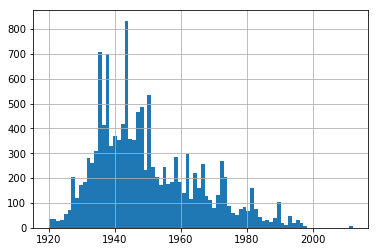

In [380]:
df_NHS_final['birth_year'].hist(bins=80)

In [330]:
#collapse in a dataframe of unique patients

### Collect info about positives in Sheffield database

In [313]:
#there will be a 'ENCRYPTED_HESID' column
Sheffdb_label_ID= 'STHFT_Study_ID'
date_birth='Date_of_birth'
gender='Sex$Item'
has_rhc= 'Flag_RHC'
#is this the right field to look at?
hospital= 'District'

cols_SFH=[Sheffdb_label_ID,gender,date_birth,has_rhc, hospital]
df_SFH=pd.read_excel(Sheffdb_tablename)
df_SFH=df_SFH[cols_SFH]
df_SFH.head(3)

,STHFT_Study_ID,Sex$Item,Date_of_birth,Flag_RHC,District
0,//Pc2tp//+P7aBWMQvoOkA==,NaN,NaT,NaN,NaN
1,//RxlcBjcresQ2VMLQR6+g==,F,1930-01-01,0.0,Manchester
2,//u35/ic3GHqRIw88szTwg==,F,1935-01-01,0.0,Bradford


In [314]:
#convert gender column in 1(Male) 2(Female)
def code_sex(x):
    
    if x=='F' :
        return 2
    elif x=='M':
        return 1
    else:
        return 0
    
df_SFH[gender]=df_SFH[gender].map(code_sex)

In [334]:
#extract year of birth
df_SFH[date_birth]=pd.to_datetime(df_SFH[date_birth],format='Y%d%b', errors='ignore')
df_SFH['birth_year']=df_SFH[date_birth].apply(lambda x: x.year)

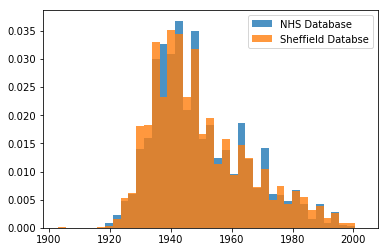

In [395]:
#a visual check about the year of birth, distributions look similar but not identical (we still do not have the full dataset howver)
bins=np.linspace(1903, 2003, 40)
plt.hist(df_NHS_final['birth_year'].dropna(), bins, label='NHS Database', normed=True, alpha=0.8)
plt.hist(df_SFH['birth_year'].dropna(), bins, label='Sheffield Databse', normed=True, alpha=0.8)
plt.legend(loc='upper right')
plt.show()

In [319]:
#create column RHC_at_SFH
cond1=(df_SFH[has_rhc]== 1.0)
cond2=(df_SFH[hospital]=='Sheffield') 
df_SFH['RHC_at SFH']=cond1 & cond2
df_SFH['RHC_at SFH'].value_counts()

False    6504
True      170
Name: RHC_at SFH, dtype: int64

### For each unique ID, check the correspondance between the daframes